# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [ ]:
import pandas as pd
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-15 04:20:13,563 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-15 04:20:15,281 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-15 04:20:15,283 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-15 04:20:15,283 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-15 04:20:15,881 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpz3ta_obz/h0mlvinx.json
2024-11-15 04:20:15,890 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

All ind vars ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']


2024-11-15 04:20:16,044 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-15 04:20:16,045 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-15 04:20:16,212 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


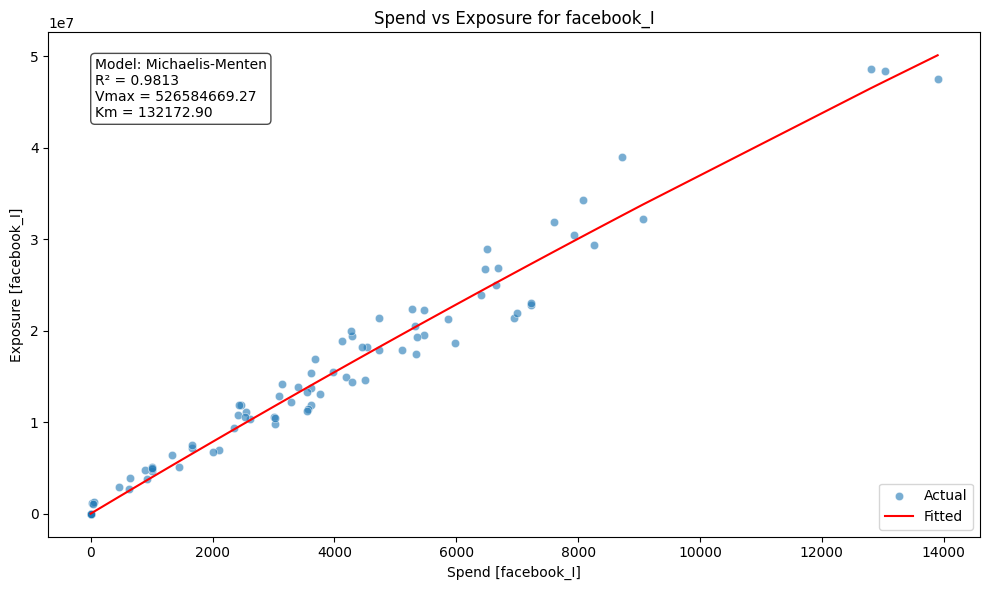

2024-11-15 04:20:16,307 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-15 04:20:16,470 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


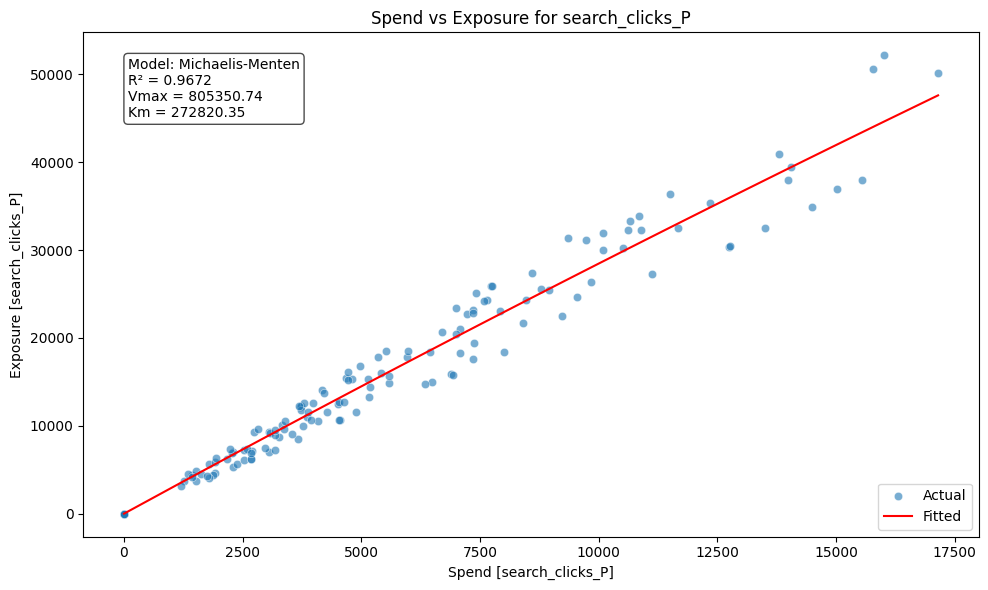

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-15 04:20:16,559 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-15 04:20:16,560 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-15 04:20:16,561 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-15 04:20:16,562 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-15 04:20:16,562 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-15 04:20:16,562 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-15 04:20:16,562 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-15 04:20:16,563 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:20:18,751 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:20:20,963 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:20:23,272 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:20:25,659 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:20:27,891 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
2024-11-15 04:20:27,899 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-15 04:20:27,899 - robyn.

Model training complete.


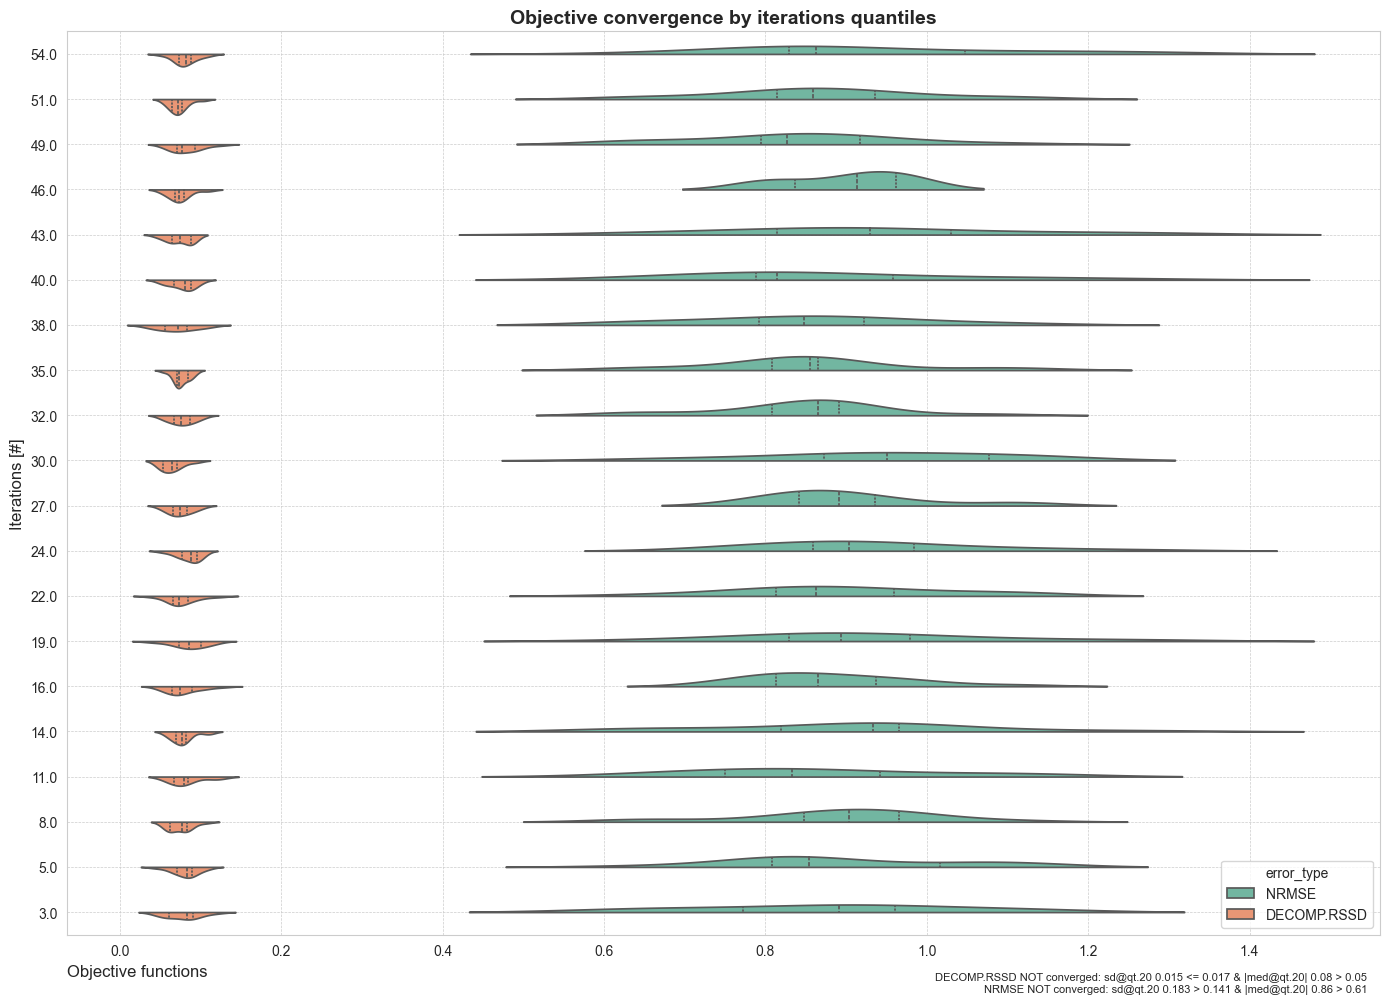

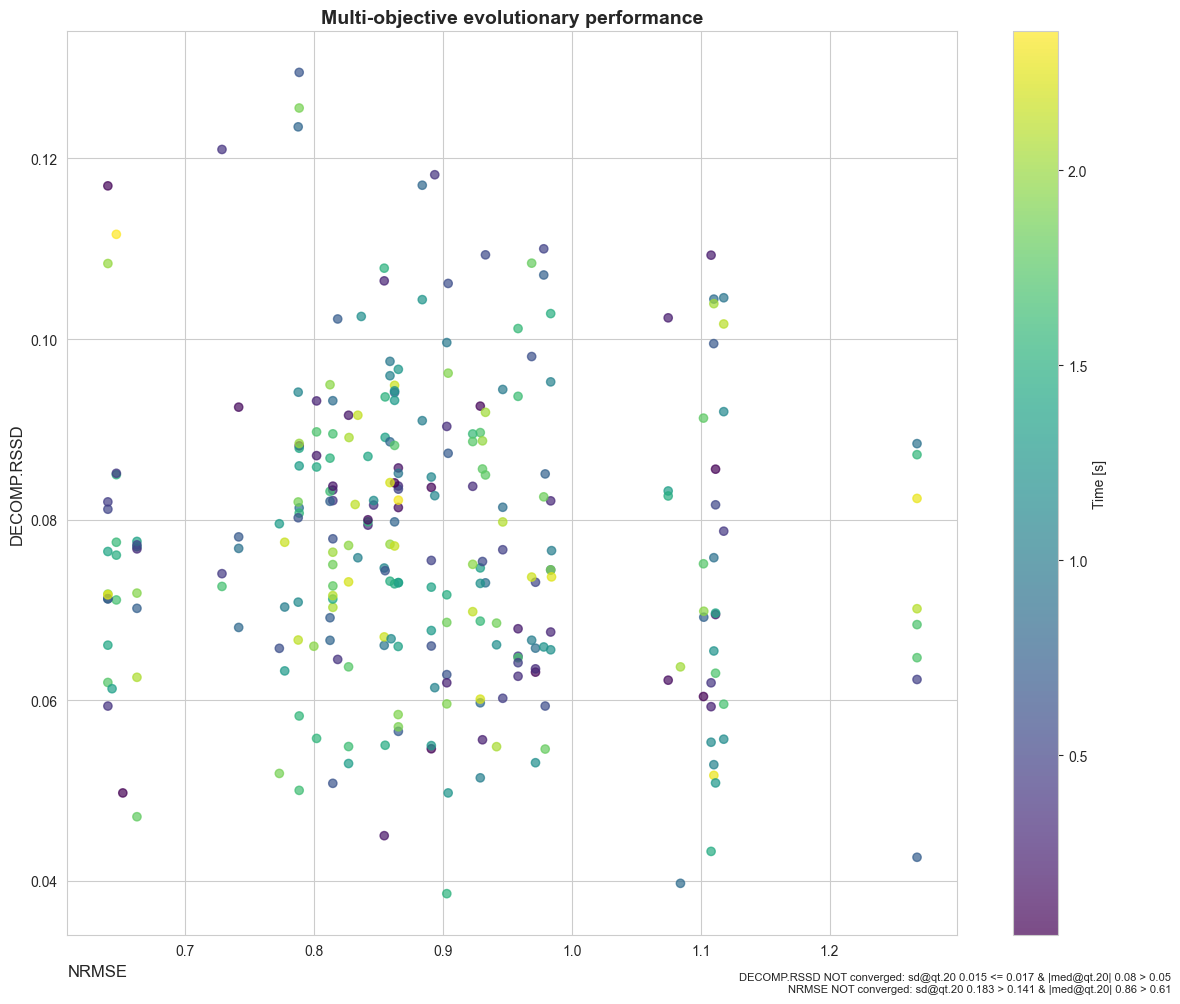

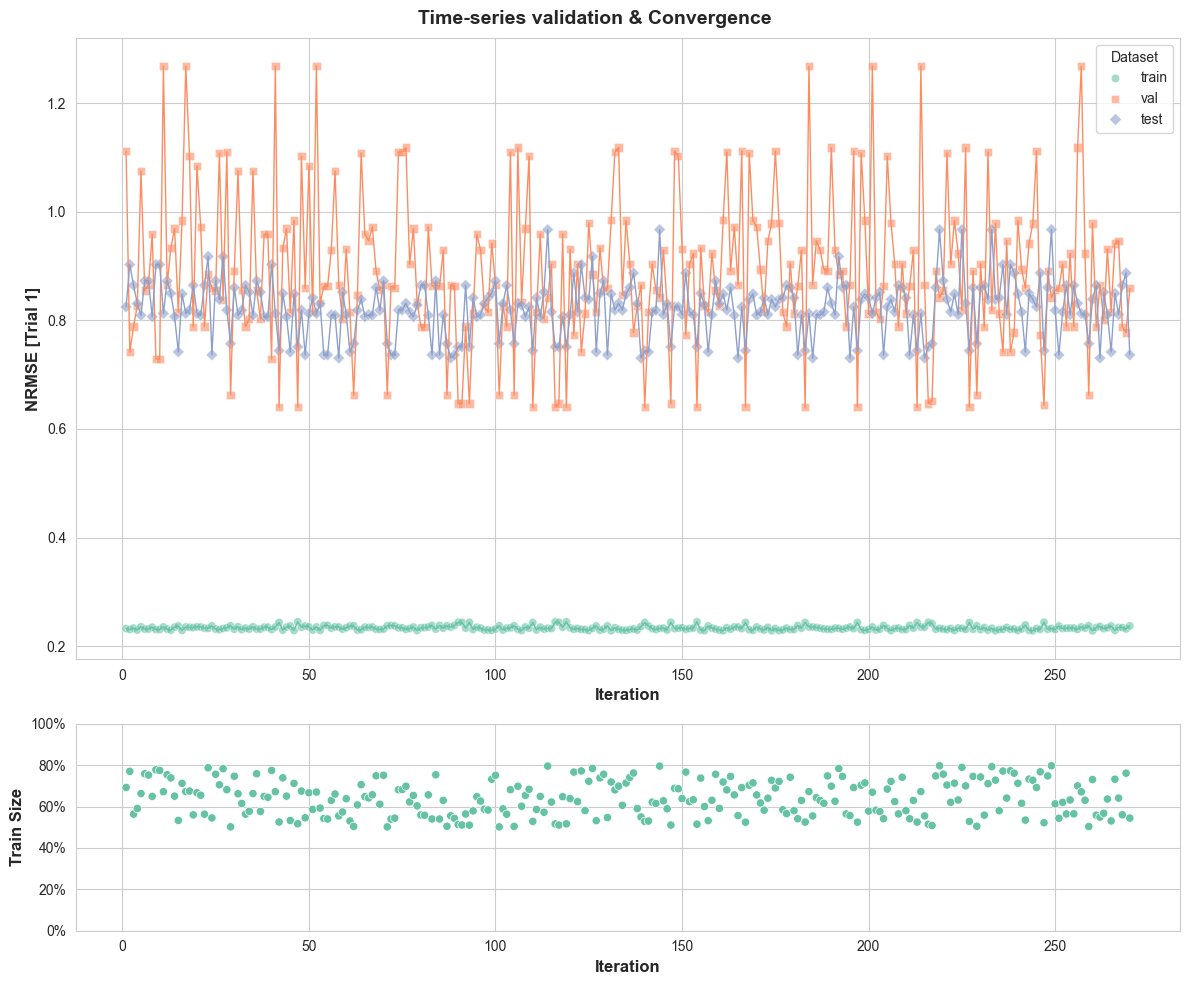

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=54, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [10]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 3_1_1


In [11]:
# Add after model training
print("Model Output Summary:")
print(f"Number of trials: {len(output_models.trials)}")
print(f"Average models per trial: {len(output_models.all_result_hyp_param) / len(output_models.trials)}")
print(f"Total unique models: {len(output_models.all_result_hyp_param['sol_id'].unique())}")

print("\nMetrics Distribution:")
metrics_df = output_models.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
print(metrics_df.describe())

# Additional validation to debug model output
print("\nColumns in result_hyp_param:")
print(output_models.all_result_hyp_param.columns.tolist())

print("\nSample rows of metrics:")
print(output_models.all_result_hyp_param[["sol_id", "nrmse", "decomp.rssd", "mape"]].head())

# Show shape of result dataframes
print("\nDataFrame Shapes:")
print(f"result_hyp_param: {output_models.all_result_hyp_param.shape}")
print(f"x_decomp_agg: {output_models.all_x_decomp_agg.shape}")
print(f"decomp_spend_dist: {output_models.all_decomp_spend_dist.shape}")

Model Output Summary:
Number of trials: 5
Average models per trial: 54.0
Total unique models: 270

Metrics Distribution:
            nrmse  decomp.rssd   mape
count  270.000000   270.000000  270.0
mean     0.891068     0.077636    0.0
std      0.140952     0.016628    0.0
min      0.640237     0.038562    0.0
25%      0.812554     0.065975    0.0
50%      0.865549     0.076609    0.0
75%      0.966307     0.088101    0.0
max      1.267842     0.129534    0.0

Columns in result_hyp_param:
['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas', 'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas', 'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'lambda', 'train_size', 'sol_id', 'Elapsed', 'ElapsedAccum', 'pos', 'trial', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'decomp.rssd

2024-11-15 04:20:29,868 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer


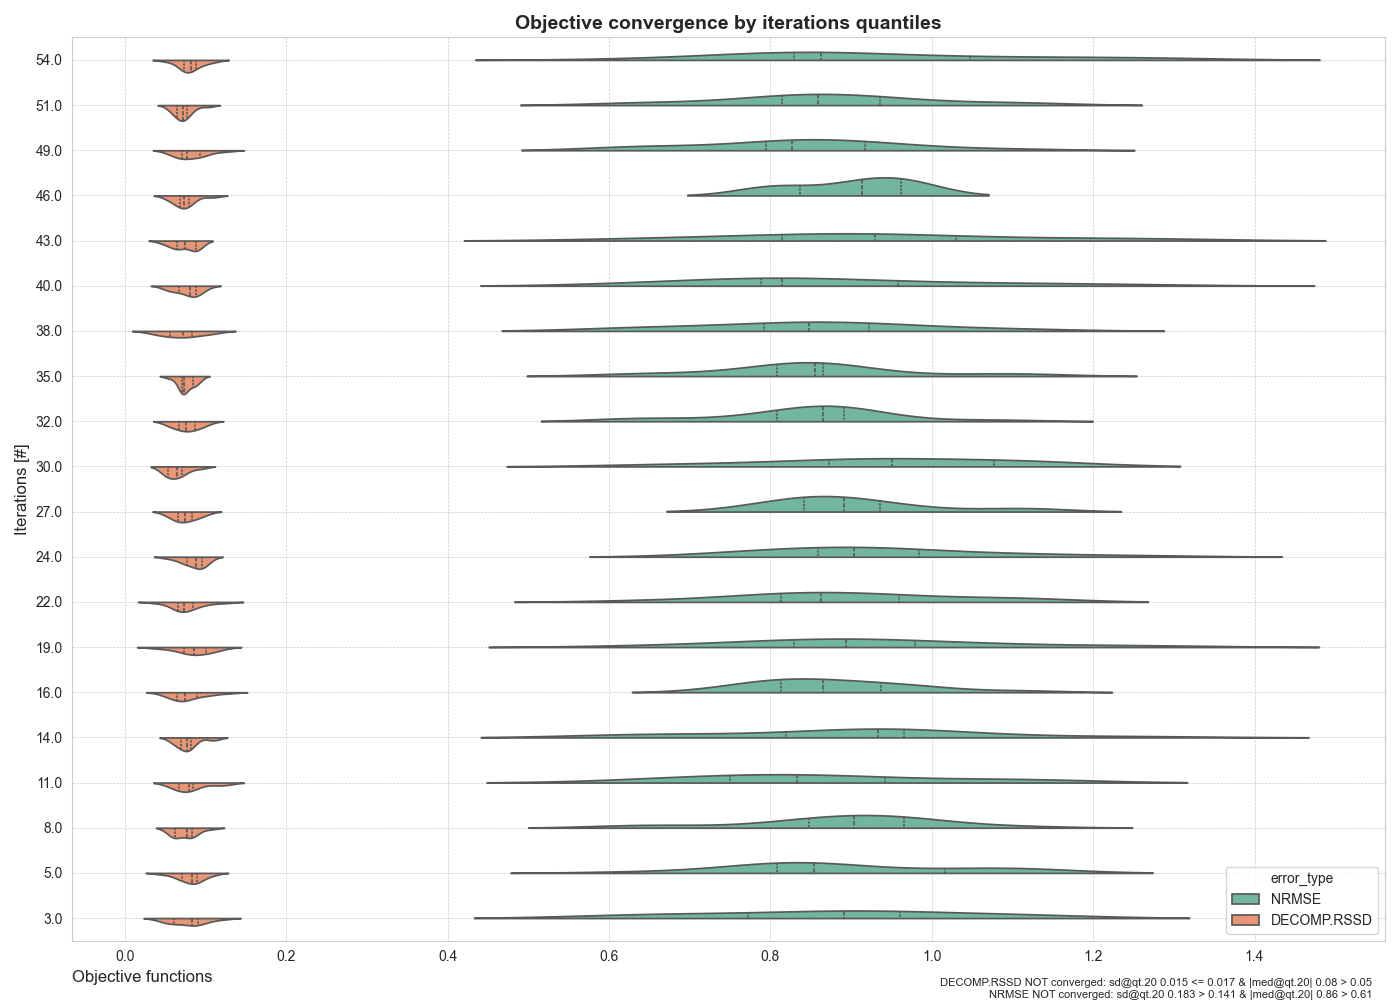

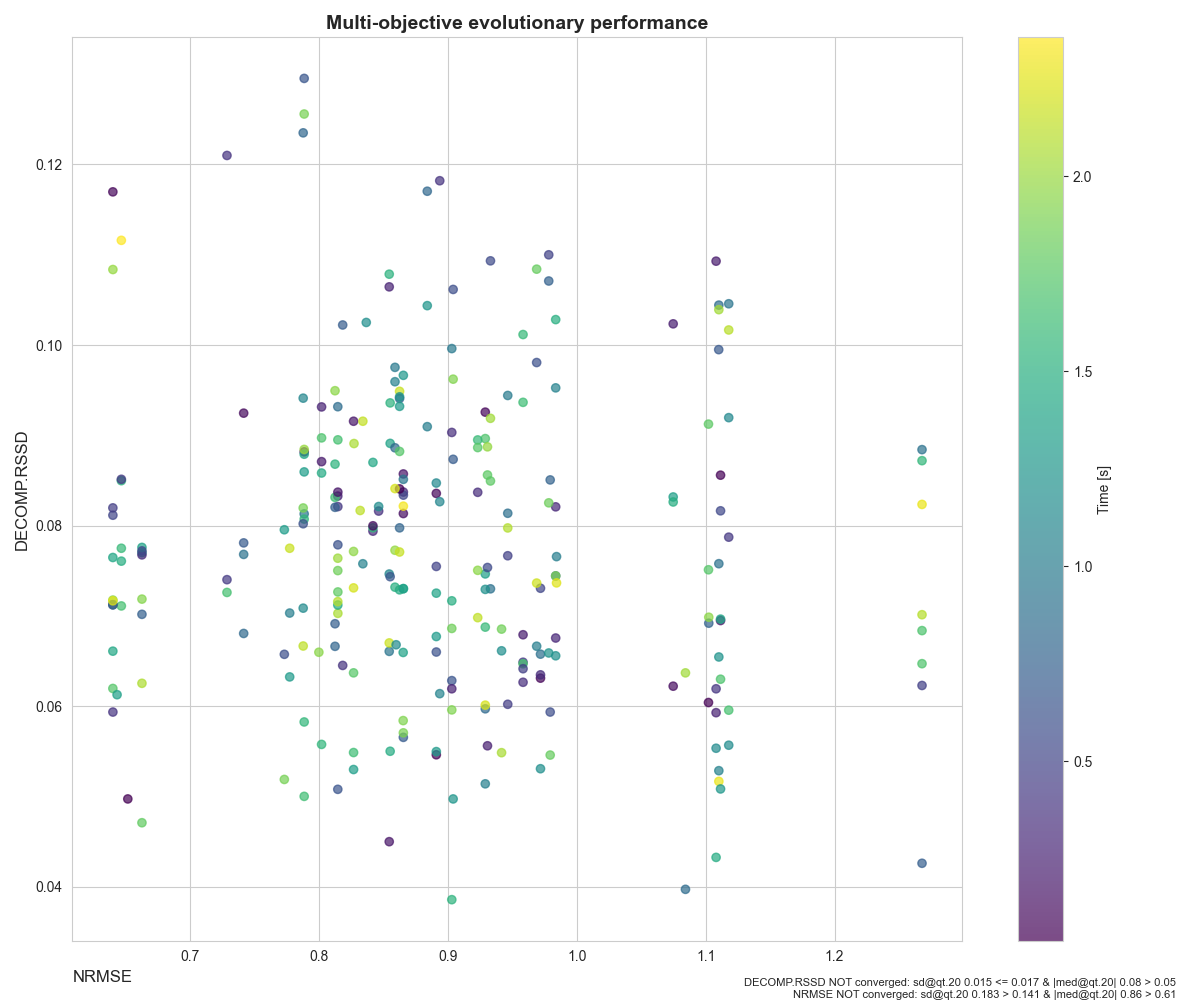

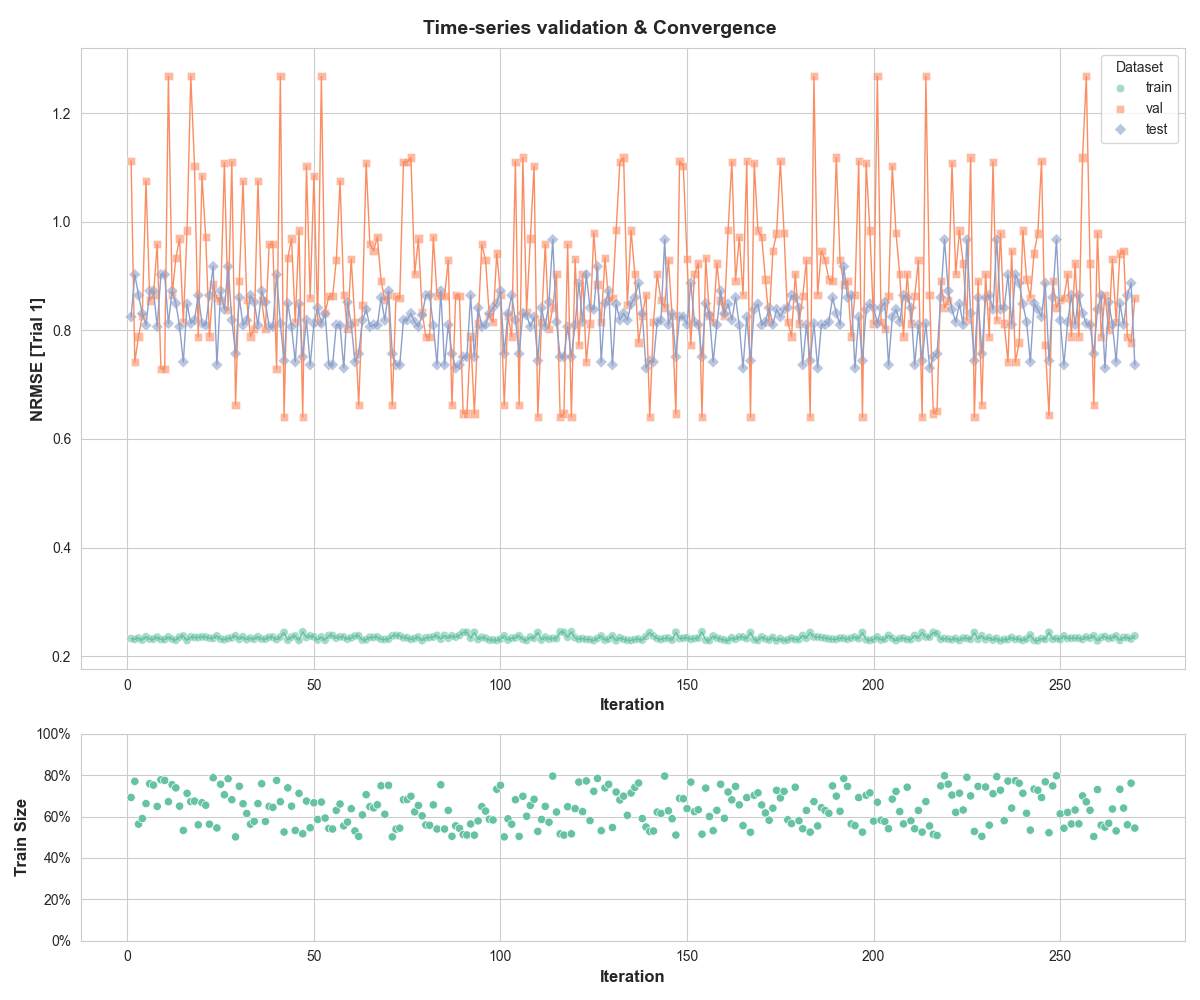

In [12]:
from IPython.display import Image, display
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from robyn.visualization.model_convergence_visualizer import ModelConvergenceVisualizer

model_visualizer = ModelConvergenceVisualizer(
    moo_distrb_plot=output_models.convergence["moo_distrb_plot"],
    ts_validation_plot=output_models.convergence["ts_validation_plot"],
    moo_cloud_plot=output_models.convergence["moo_cloud_plot"],
)

# 1. Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    model_visualizer.display_moo_distrb_plot()

# 2. Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    model_visualizer.display_moo_cloud_plot()

# 3. Display time series validation and convergence plots
if "ts_validation_plot" in output_models.convergence:
    model_visualizer.display_ts_validation_plot()

In [13]:
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer
%load_ext autoreload
%autoreload 2

In [14]:
# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data)

In [15]:
# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2024-11-15 04:20:29 [INFO] Starting Pareto optimization
2024-11-15 04:20:29 [INFO] Starting model data aggregation
2024-11-15 04:20:29 [INFO] Computing Pareto fronts
2024-11-15 04:20:29 [INFO] Pareto front computation completed
2024-11-15 04:20:29 [INFO] Preparing Pareto data
2024-11-15 04:20:29 [INFO] Number of Pareto-optimal solutions found: 220
2024-11-15 04:20:29 [INFO] Selected 10 Pareto-fronts containing 103 candidates
2024-11-15 04:20:29 [INFO] Filtering data for selected Pareto fronts...
2024-11-15 04:20:29 [INFO] Calculating response curves for 515 models' media variables...
2024-11-15 04:20:29,984 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:29,995 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 1_2_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


Processing rows:   0%|          | 0/515 [00:00<?, ?it/s]2024-11-15 04:20:30,004 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,028 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,031 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,034 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,050 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,054 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bo

Error processing row for sol_id 1_2_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_2_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_2_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_2_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error 

2024-11-15 04:20:30,212 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,223 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,233 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:   5%|▍         | 24/515 [00:00<00:04, 104.49it/s]2024-11-15 04:20:30,243 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,254 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,265 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 1_25_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_25_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_25_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_25_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_29_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:30,427 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,438 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,448 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,458 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,469 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:   9%|▉         | 46/515 [00:00<00:04, 98.75it/s] 2024-11-15 04:20:30,479 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 1_37_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_37_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_37_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_40_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_40_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_40_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_40_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_40_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_42_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_42_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:30,643 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,654 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,664 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,674 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  13%|█▎        | 67/515 [00:00<00:04, 99.73it/s]2024-11-15 04:20:30,684 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,694 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is 

Error processing row for sol_id 1_47_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_47_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_47_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_6_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_6_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Erro

2024-11-15 04:20:30,846 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,856 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,866 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,877 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:30,888 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  17%|█▋        | 87/515 [00:00<00:04, 97.29it/s]2024-11-15 04:20:30,899 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is 

Error processing row for sol_id 2_14_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_14_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_16_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_16_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_16_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:31,076 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,086 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,097 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  21%|██        | 107/515 [00:01<00:04, 96.40it/s]2024-11-15 04:20:31,107 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,117 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,127 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_25_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_27_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_27_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_27_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_27_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:31,284 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,293 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,304 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  25%|██▍       | 127/515 [00:01<00:04, 96.35it/s]2024-11-15 04:20:31,314 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,324 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,335 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_34_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_35_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_35_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_35_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_35_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_35_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:31,499 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,509 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,519 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  29%|██▊       | 148/515 [00:01<00:03, 96.94it/s]2024-11-15 04:20:31,529 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,540 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,550 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_38_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_39_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_39_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_39_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_39_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_39_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_43_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:31,707 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,717 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,728 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  33%|███▎      | 168/515 [00:01<00:03, 96.15it/s]2024-11-15 04:20:31,738 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,748 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,759 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_46_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_46_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_46_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_46_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_48_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:31,925 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  37%|███▋      | 188/515 [00:01<00:03, 97.57it/s]2024-11-15 04:20:31,935 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,946 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,957 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,968 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:31,979 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_8_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_8_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_8_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_8_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_11_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error proce

2024-11-15 04:20:32,141 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  40%|████      | 208/515 [00:02<00:03, 93.72it/s]2024-11-15 04:20:32,152 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,163 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,173 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,184 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,195 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_14_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_16_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:32,354 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,364 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  44%|████▍     | 228/515 [00:02<00:03, 93.25it/s]2024-11-15 04:20:32,375 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,386 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,396 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,407 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_28_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_30_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:32,572 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  48%|████▊     | 248/515 [00:02<00:02, 95.78it/s]2024-11-15 04:20:32,582 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,592 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,603 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,613 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,624 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_32_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_32_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_32_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_38_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_38_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:32,770 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,781 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  52%|█████▏    | 268/515 [00:02<00:02, 94.07it/s]2024-11-15 04:20:32,792 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,803 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,813 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:32,823 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_43_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_43_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_43_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_49_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_49_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:32,988 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  56%|█████▌    | 288/515 [00:02<00:02, 95.96it/s]2024-11-15 04:20:32,999 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,011 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,021 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,032 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,042 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_52_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_52_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_52_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_5_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_5_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error pro

2024-11-15 04:20:33,202 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  60%|█████▉    | 308/515 [00:03<00:02, 93.60it/s]2024-11-15 04:20:33,213 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,223 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,234 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,244 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,255 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_14_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_14_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:33,412 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,423 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  64%|██████▎   | 328/515 [00:03<00:02, 91.88it/s]2024-11-15 04:20:33,434 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,445 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,456 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,468 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_25_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_25_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_25_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_31_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_31_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:33,641 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  68%|██████▊   | 348/515 [00:03<00:01, 92.87it/s]2024-11-15 04:20:33,651 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,662 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,672 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,683 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,694 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_35_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_35_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_35_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_44_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_44_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:33,841 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,853 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,863 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  72%|███████▏  | 369/515 [00:03<00:01, 94.23it/s]2024-11-15 04:20:33,874 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,884 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:33,895 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_50_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_50_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_50_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_1_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_1_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Erro

2024-11-15 04:20:34,062 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,072 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  76%|███████▌  | 389/515 [00:04<00:01, 92.38it/s]2024-11-15 04:20:34,083 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,093 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,103 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,114 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_6_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_6_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_11_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_11_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-15 04:20:34,277 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,299 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  77%|███████▋  | 399/515 [00:04<00:01, 67.99it/s]2024-11-15 04:20:34,310 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,327 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,341 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,353 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_11_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_11_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_11_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:34,519 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,529 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  82%|████████▏ | 420/515 [00:04<00:01, 80.91it/s]2024-11-15 04:20:34,539 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,550 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,560 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,570 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_20_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_20_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_23_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_23_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_23_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:34,735 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,745 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  85%|████████▌ | 440/515 [00:04<00:00, 86.99it/s]2024-11-15 04:20:34,755 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,766 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,778 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,789 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_30_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_31_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_31_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_31_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_31_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_31_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_32_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_32_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_32_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_32_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:34,957 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  89%|████████▉ | 460/515 [00:04<00:00, 89.64it/s]2024-11-15 04:20:34,967 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,978 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,989 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:34,999 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,010 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_35_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_35_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_36_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_36_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_36_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_36_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_36_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_37_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_37_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_37_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:35,168 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,179 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  93%|█████████▎| 480/515 [00:05<00:00, 93.37it/s]2024-11-15 04:20:35,189 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,200 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,211 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,222 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_43_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_45_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_45_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_45_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_45_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_45_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_46_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_46_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_46_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_46_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-15 04:20:35,387 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,397 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  97%|█████████▋| 500/515 [00:05<00:00, 91.58it/s]2024-11-15 04:20:35,407 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,417 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,427 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-15 04:20:35,438 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_49_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_50_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_50_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_50_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_50_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_50_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_52_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_52_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_52_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_52_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-15 04:20:35 [INFO] Processing Pareto front 2
2024-11-15 04:20:35 [INFO] Pareto-Front: 2 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-15 04:20:35 [INFO] Processing Pareto front 3
2024-11-15 04:20:35 [INFO] Pareto-Front: 3 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-15 04:20:35 [INFO] Processing Pareto front 4
2024-11-15 04:20:35 [INFO] Pareto-Front: 4 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-15 04:20:35 [INFO] Processing Pareto front 5
2024-11-15 04:20:35 [INFO] Pareto-Front: 5 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-15 04:20:35 [INFO] Processing Pareto front 6
2024-11-15 04:20:35 [INFO] Pareto-Front: 6 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-15 04:20:35 [INFO] Processing Pareto front 7
2024-11-15 04:20:35 [INFO] Pareto-Front: 7 [0 models]
Processing Solutions: 0solution [00:00, 

In [16]:
# 5. Check results
print("Pareto Optimization Results:")
print(f"Number of Pareto fronts: {pareto_result.pareto_solutions}")
print(f"MediaVecCollect: {pareto_result.media_vec_collect.shape, pareto_result.media_vec_collect}")
print("\Hyper parameter solutions:")
print(pareto_result.result_hyp_param)

print("\nAggregated decomposition results:")
print(pareto_result.x_decomp_agg)
print("\result Calibration:")
print(pareto_result.result_calibration)
print("\nx Decomp Vec Collect:")
print(pareto_result.x_decomp_vec_collect.shape, pareto_result.x_decomp_vec_collect)
print("\nCarryover percentage all:")
print(pareto_result.df_caov_pct_all.shape, pareto_result.df_caov_pct_all)
print("\Plot Data Collected")
print("NUMBER OF PLOTS Data collected for:", len(pareto_result.plot_data_collect))
print("Plot data for solid 5_221_9", pareto_result.plot_data_collect)

# 6. Validate logic
assert pareto_result.pareto_fronts == "auto" or isinstance(
    pareto_result.pareto_fronts, int
), "Invalid pareto_fronts value"
assert not pareto_result.result_hyp_param.empty, "Empty result_hyp_param DataFrame"
assert not pareto_result.x_decomp_agg.empty, "Empty x_decomp_agg DataFrame"

print("\nAll assertions passed. The optimize function is working as expected.")

Pareto Optimization Results:
Number of Pareto fronts: set()
MediaVecCollect: ((0, 0), Empty DataFrame
Columns: []
Index: [])
\Hyper parameter solutions:
     facebook_S_thetas  facebook_S_alphas  facebook_S_gammas  print_S_thetas  \
0             0.283596           1.843564           0.518895        0.347031   
1             0.102470           0.677168           0.367063        0.333238   
2             0.130170           0.683583           0.806549        0.292438   
3             0.209519           2.107668           0.390941        0.236971   
4             0.140576           2.693035           0.572054        0.176611   
..                 ...                ...                ...             ...   
265           0.256421           0.746821           0.801512        0.245181   
266           0.052607           2.371266           0.779008        0.175338   
267           0.273371           2.583180           0.345582        0.391040   
268           0.224161           2.152948      

In [17]:
len(pareto_result.pareto_solutions)

0

## Allocator

In [18]:
## Step 1: Setup and Import

# Import necessary Robyn classes
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode
from robyn.allocator.budget_allocator import BudgetAllocator
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from robyn.visualization.allocator_plotter import AllocationPlotter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
print(pareto_result.result_hyp_param["sol_id"])

0       1_1_1
1       1_2_1
2       1_3_1
3       1_4_1
4       1_5_1
        ...  
265    5_50_1
266    5_51_1
267    5_52_1
268    5_53_1
269    5_54_1
Name: sol_id, Length: 270, dtype: object


In [20]:
# Make sure to use the correct model ID from your pareto results
available_models = pareto_result.result_hyp_param["sol_id"].unique()  # or 'solID' if that's the column name
print(f"Available models: {available_models}")
# Initialize allocator with a valid model ID
select_model = available_models[0]  # Use first available model

# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    pareto_result=pareto_result,  # Get ParetoResult from import_output_collect()
    select_model=select_model,
)

2024-11-15 04:20:35,739 - robyn.allocator.budget_allocator - INFO - Initializing BudgetAllocator
2024-11-15 04:20:35,740 - robyn.allocator.media_response - INFO - Initializing MediaResponseParamsCalculator
2024-11-15 04:20:35,740 - robyn.allocator.allocation_optimizer - INFO - Initializing AllocationOptimizer
2024-11-15 04:20:35,740 - robyn.allocator.media_response - INFO - Starting media response parameters calculation for model 1_1_1
2024-11-15 04:20:35,741 - robyn.allocator.media_response - WARNING - No coefficient data found for facebook_S, using default coefficient of 1.0
2024-11-15 04:20:35,742 - robyn.allocator.media_response - WARNING - No coefficient data found for ooh_S, using default coefficient of 1.0
2024-11-15 04:20:35,742 - robyn.allocator.media_response - WARNING - No coefficient data found for print_S, using default coefficient of 1.0
2024-11-15 04:20:35,743 - robyn.allocator.media_response - WARNING - No coefficient data found for search_S, using default coefficient o

Available models: ['1_1_1' '1_2_1' '1_3_1' '1_4_1' '1_5_1' '1_6_1' '1_7_1' '1_8_1' '1_9_1'
 '1_10_1' '1_11_1' '1_12_1' '1_13_1' '1_14_1' '1_15_1' '1_16_1' '1_17_1'
 '1_18_1' '1_19_1' '1_20_1' '1_21_1' '1_22_1' '1_23_1' '1_24_1' '1_25_1'
 '1_26_1' '1_27_1' '1_28_1' '1_29_1' '1_30_1' '1_31_1' '1_32_1' '1_33_1'
 '1_34_1' '1_35_1' '1_36_1' '1_37_1' '1_38_1' '1_39_1' '1_40_1' '1_41_1'
 '1_42_1' '1_43_1' '1_44_1' '1_45_1' '1_46_1' '1_47_1' '1_48_1' '1_49_1'
 '1_50_1' '1_51_1' '1_52_1' '1_53_1' '1_54_1' '2_1_1' '2_2_1' '2_3_1'
 '2_4_1' '2_5_1' '2_6_1' '2_7_1' '2_8_1' '2_9_1' '2_10_1' '2_11_1'
 '2_12_1' '2_13_1' '2_14_1' '2_15_1' '2_16_1' '2_17_1' '2_18_1' '2_19_1'
 '2_20_1' '2_21_1' '2_22_1' '2_23_1' '2_24_1' '2_25_1' '2_26_1' '2_27_1'
 '2_28_1' '2_29_1' '2_30_1' '2_31_1' '2_32_1' '2_33_1' '2_34_1' '2_35_1'
 '2_36_1' '2_37_1' '2_38_1' '2_39_1' '2_40_1' '2_41_1' '2_42_1' '2_43_1'
 '2_44_1' '2_45_1' '2_46_1' '2_47_1' '2_48_1' '2_49_1' '2_50_1' '2_51_1'
 '2_52_1' '2_53_1' '2_54_1' '3_1_1' '3_2_1

## Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [21]:
# Create base constraints matching R example
channel_constraints = AllocationConstraints(
    channel_constr_low={
        "tv_S": 0.7,  # -30% from base
        "ooh_S": 0.7,
        "print_S": 0.7,
        "facebook_S": 0.7,
        "search_S": 0.7,
    },
    channel_constr_up={
        "tv_S": 1.2,  # +20% from base
        "ooh_S": 1.5,  # +50% from base
        "print_S": 1.5,
        "facebook_S": 1.5,
        "search_S": 1.5,
    },
    channel_constr_multiplier=3.0,
)

# Configure max response scenario
max_response_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result = allocator.allocate(max_response_config)

# Print results
print(
    f"""
Model ID: {select_model}
Scenario: {max_response_config.scenario}
Use case: {result.metrics.get('use_case', '')}
Window: {result.metrics.get('date_range_start')}:{result.metrics.get('date_range_end')} ({result.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result.metrics.get('spend_lift_pct', 0):.1f}% ({result.metrics.get('spend_lift_abs', 0):+.0f}K)
Total Response Increase (Optimized): {result.metrics.get('response_lift', 0)*100:.1f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result.optimal_allocations[result.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-15 04:20:35,765 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-15 04:20:35,766 - robyn.allocator.budget_allocator - WARNING - Found zero mean spend for channels: ['tv_S' 'ooh_S' 'print_S' 'search_S']
2024-11-15 04:20:35,768 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,768 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,769 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,769 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,769 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,769 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-15 04:20:35,770 - robyn.allocator.bu


Model ID: 1_1_1
Scenario: max_response
Use case: 
Window: 2019-11-11 00:00:00:2019-11-11 00:00:00 (1 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 0.0% (+0K)
Total Response Increase (Optimized): 4.5%

Allocation Summary:


- tv_S:
  Optimizable bound: [-30%, 20%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 1.64% -> Optimized bounded: 1.09%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- ooh_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.45% -> Optimized bounded: 0.29%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- print_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.76% -> Optimized bounded: 0.36%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- facebook_S:
  Optimizable bound: [-30%, 50%

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [22]:
### Scenario 3: Default Target Efficiency (Target ROAS or CPA)
print("\nScenario 3: Target efficiency optimization")

# Create constraints matching R's implementation
default_channel_constraints = AllocationConstraints(
    channel_constr_low={
        channel: 0.1 for channel in mmm_data.mmmdata_spec.paid_media_spends  # -90% from base for all channels
    },
    channel_constr_up={
        channel: 10.0 for channel in mmm_data.mmmdata_spec.paid_media_spends  # +900% from base for all channels
    },
    channel_constr_multiplier=1.0,  # Don't extend bounds for target efficiency
    is_target_efficiency=True,  # Flag this as target efficiency scenario
)

# Create configuration for target efficiency scenario
target_efficiency_config = AllocationConfig(
    scenario=OptimizationScenario.TARGET_EFFICIENCY,
    constraints=default_channel_constraints,
    date_range="all",  # Use all dates like in R version
    target_value=None,  # Will use default 80% of initial ROAS or 120% of initial CPA
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result3 = allocator.allocate(target_efficiency_config)

# Print results matching R format
print(
    f"""
Model ID: {select_model}
Scenario: {target_efficiency_config.scenario}
Use case: {result3.metrics.get('use_case', '')}
Window: {result3.metrics.get('date_range_start')}:{result3.metrics.get('date_range_end')} ({result3.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result3.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result3.metrics.get('spend_lift_pct', 0):.0f}% ({result3.metrics.get('spend_lift_abs', 0):.0f})
Total Response Increase (Optimized): {result3.metrics.get('response_lift', 0)*100:.0f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result3.optimal_allocations[result3.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-15 04:20:35,838 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-15 04:20:35,840 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,840 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,841 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-15 04:20:35,841 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0001
2024-11-15 04:20:35,841 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0001
2024-11-15 04:20:35,842 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-15 04:20:35,842 - robyn.allocator.budget_allocator - INFO - Running optimization for scenario: OptimizationScenario.TARGET_EFFICIENCY
2024-11-15 04:20:35,842 - robyn.allocator.budge


Scenario 3: Target efficiency optimization

Model ID: 1_1_1
Scenario: target_efficiency
Use case: all_historical_vec + historical_budget
Window: 2015-11-23 00:00:00:2019-11-11 00:00:00 (208 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: -2% (-2)
Total Response Increase (Optimized): -22%

Allocation Summary:


- tv_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 21.25% -> Optimized bounded: 21.82%
  Initial response share: 18.11% -> Optimized bounded: 23.23%
  Initial abs. mean spend: 14.844K -> Optimized: 14.870K [Delta = 0%]


- ooh_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 61.87% -> Optimized bounded: 63.54%
  Initial response share: 15.32% -> Optimized bounded: 19.66%
  Initial abs. mean spend: 43.218K -> Optimized: 43.304K [Delta = 0%]


- print_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 5.34% -> Optimized bounded: 5.25%
  Initial response share: 6.54% -> Optimized bounded: 7.74%
  Initial abs. mean

2024-11-15 04:20:35,892 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-15 04:20:35,893 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-15 04:20:35,893 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $17,088.90
Total Optimal Spend: $17,088.90
Spend Lift: +0.0%
Response Lift: +4.5%)
2024-11-15 04:20:35,894 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-15 04:20:35,894 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-15 04:20:35,894 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $69,851.44
Total Optimal Spend: $68,151.30
Spend Lift: -2.4%
Response Lift: -21.9%)
2024-11-15 04:20:35,894 - robyn.visualization

Max Response Scenario Plots:
--------------------------------------------------


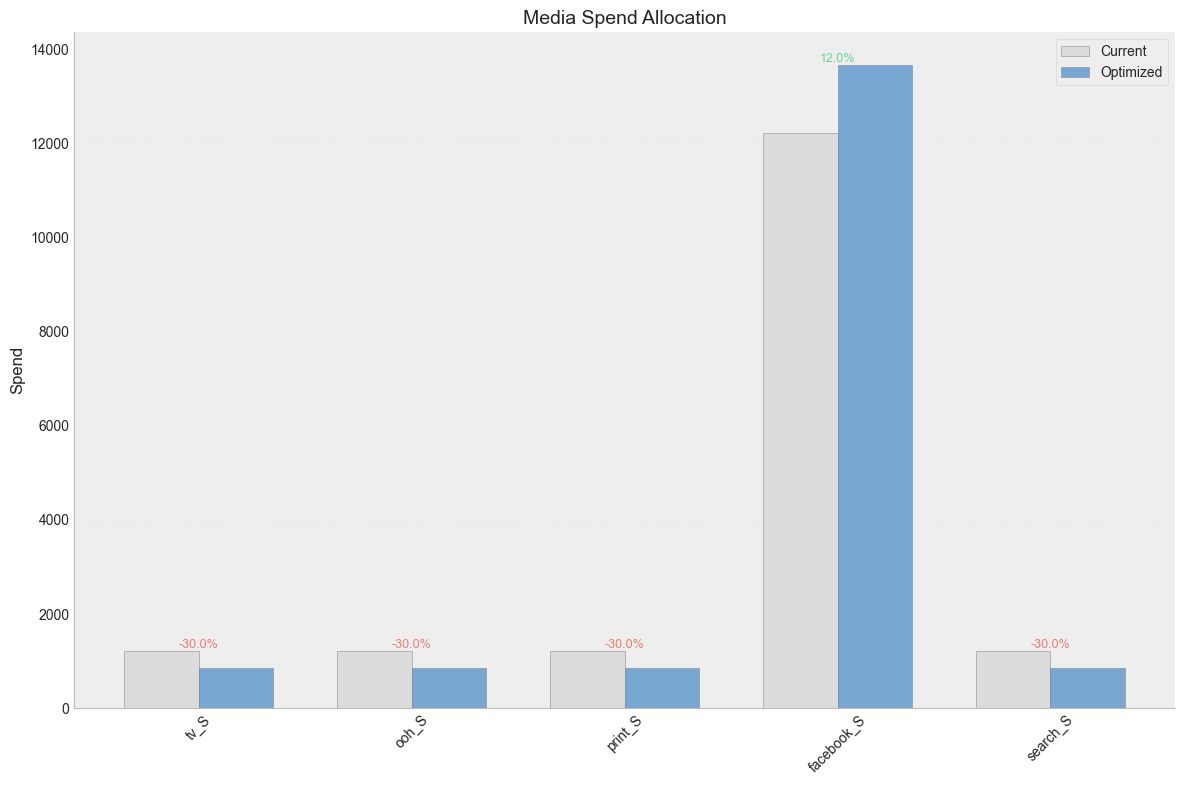

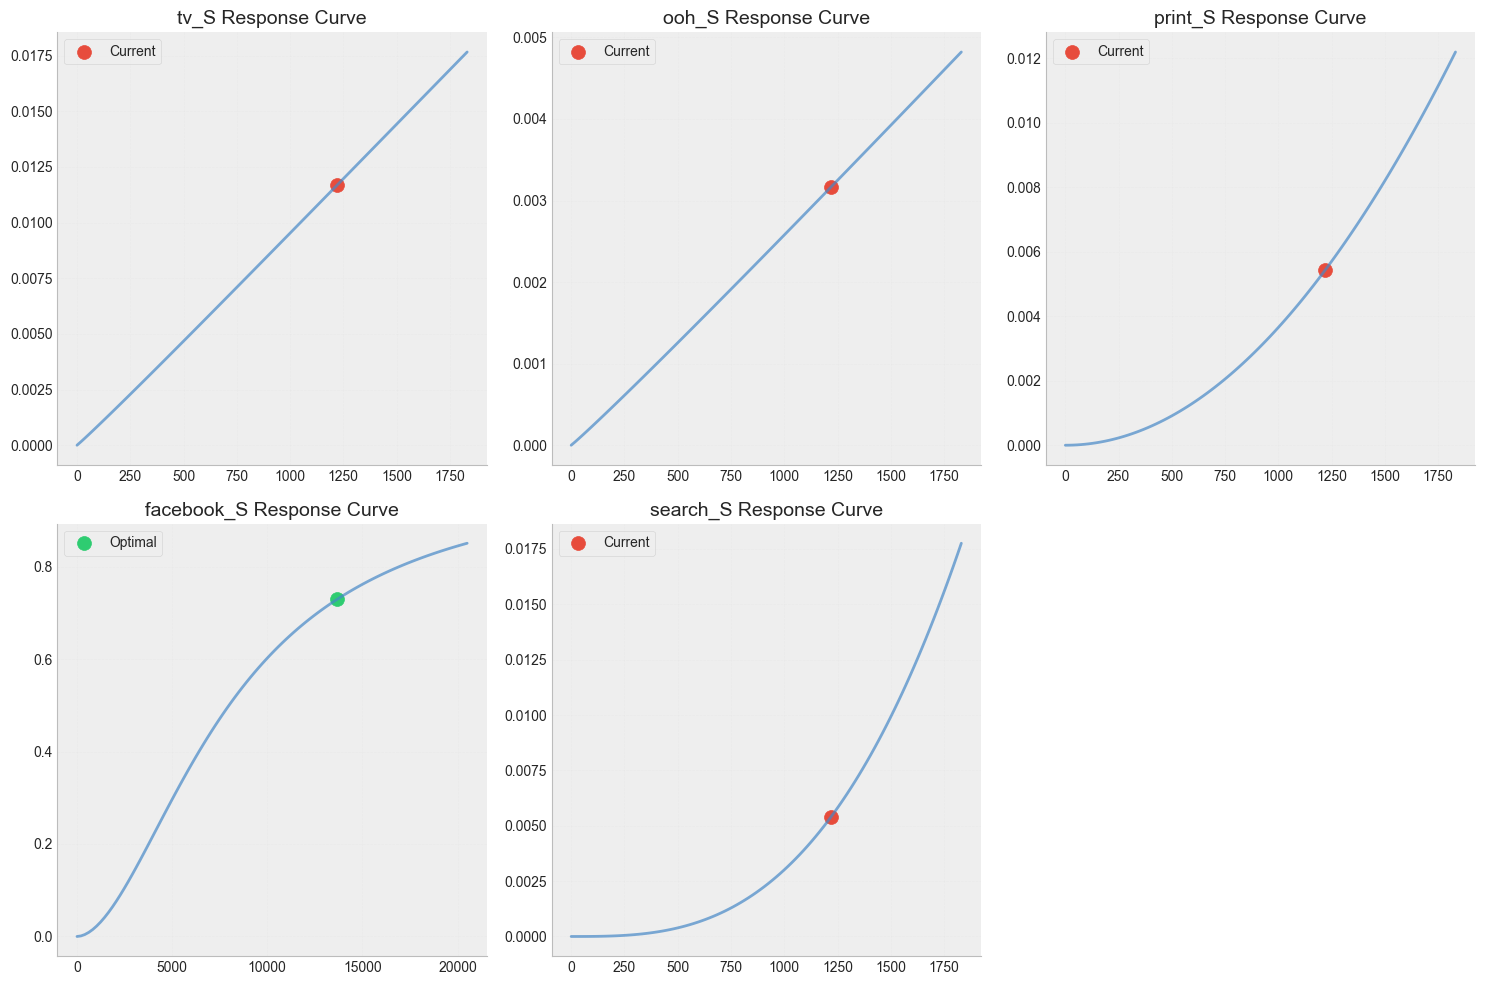

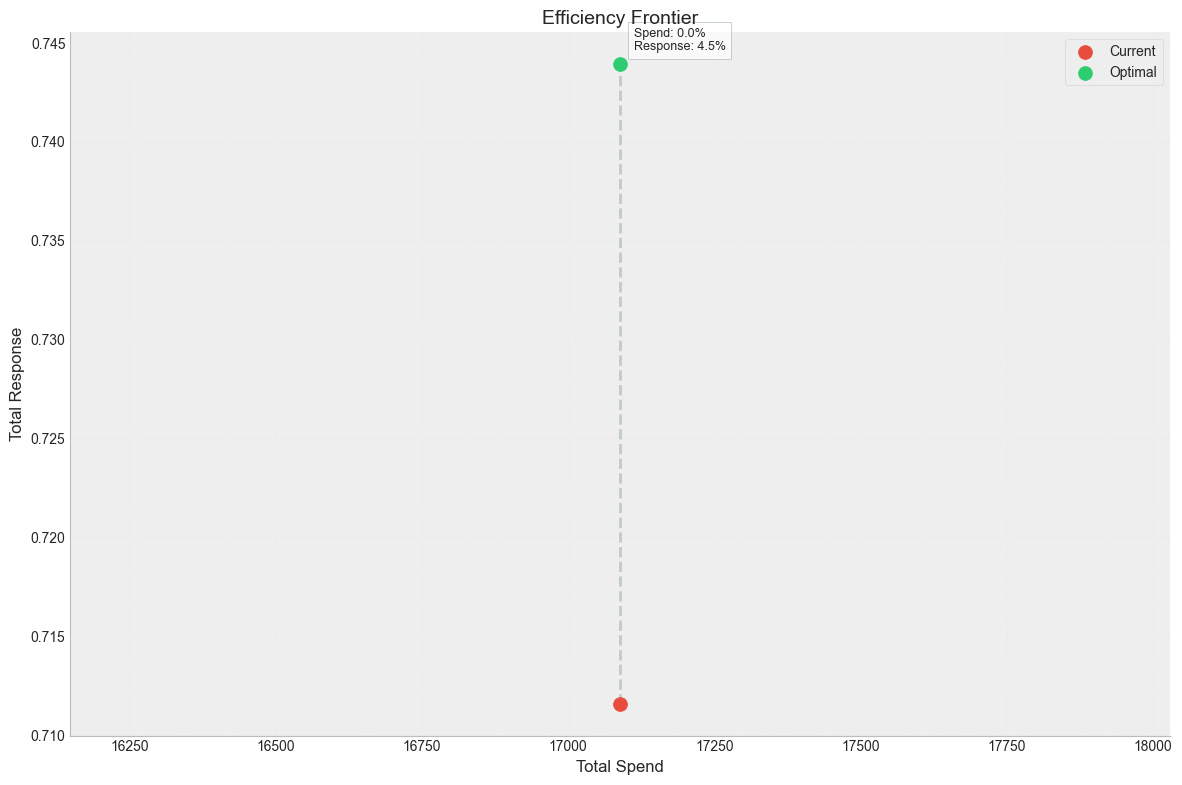

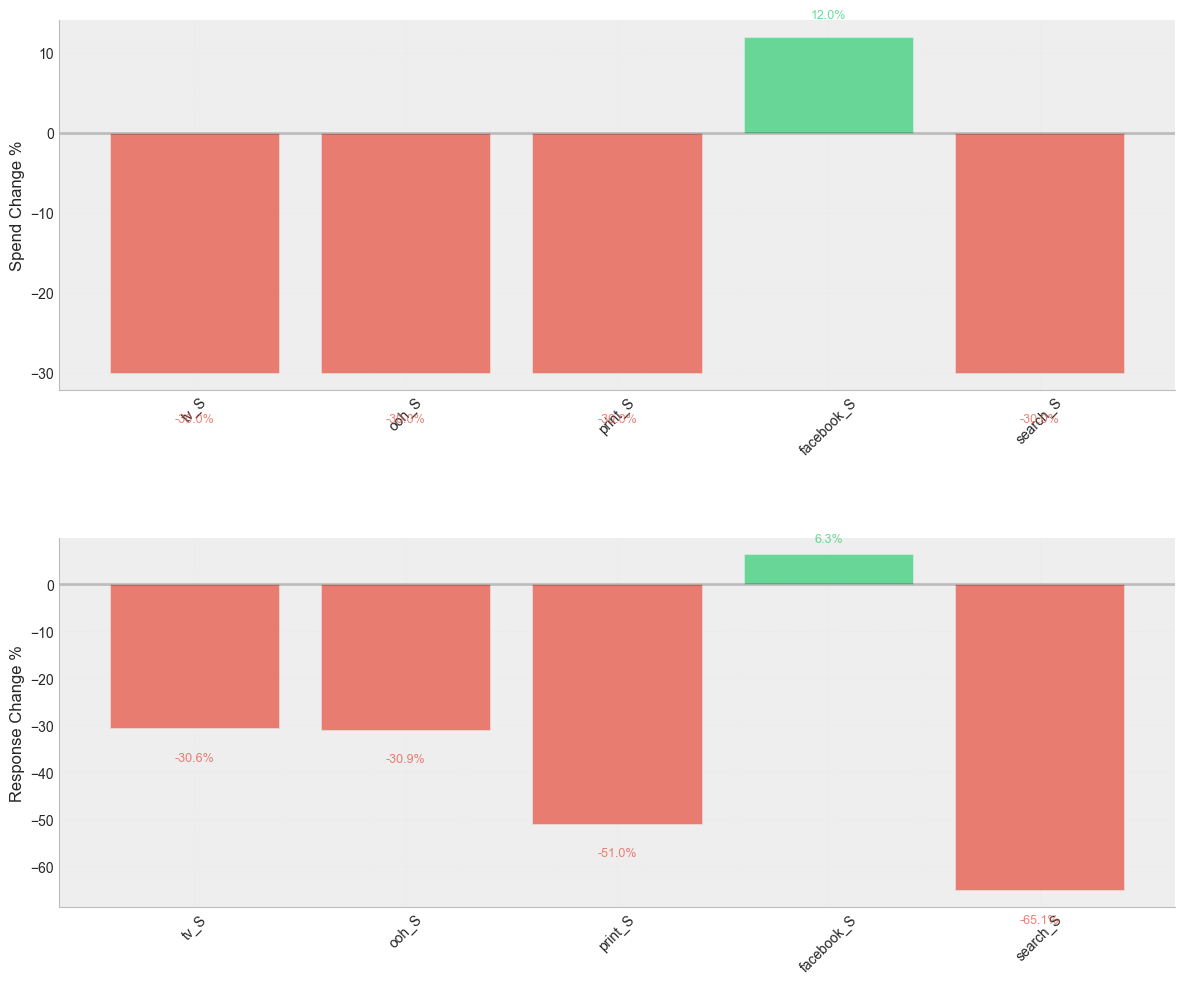

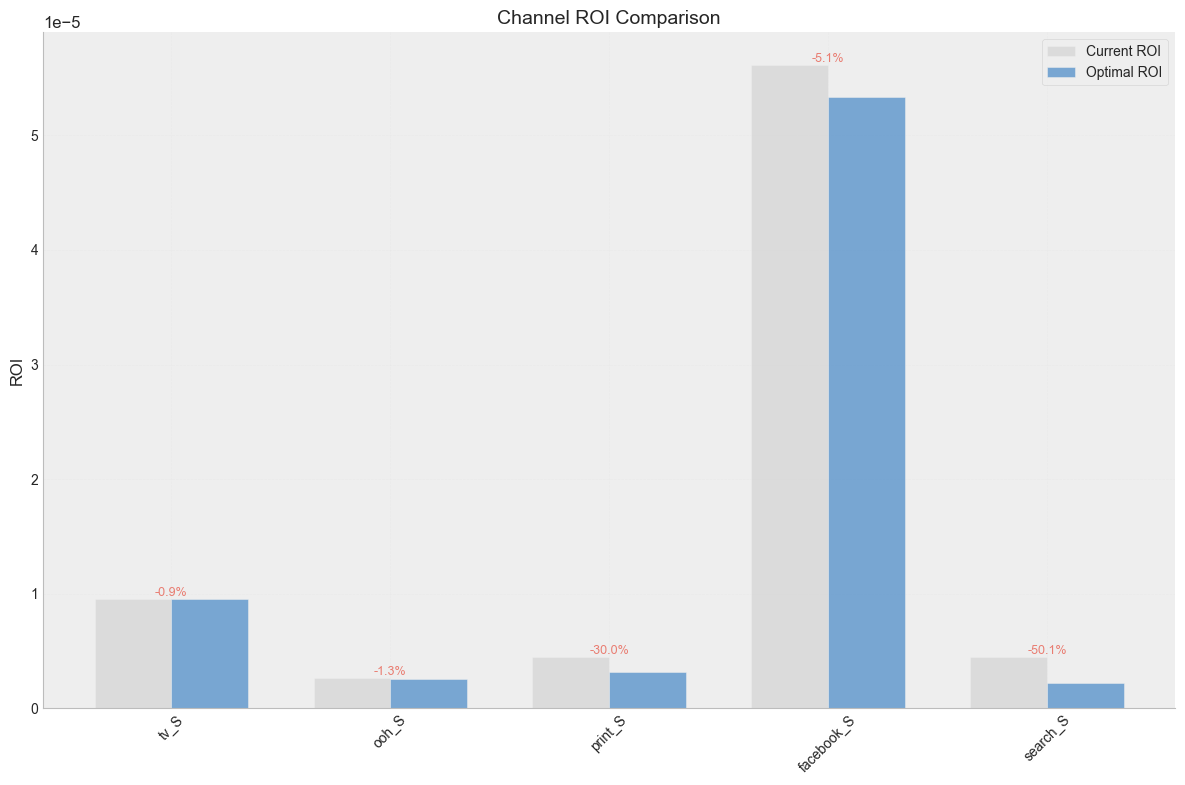


Target Efficiency Scenario Plots:
--------------------------------------------------


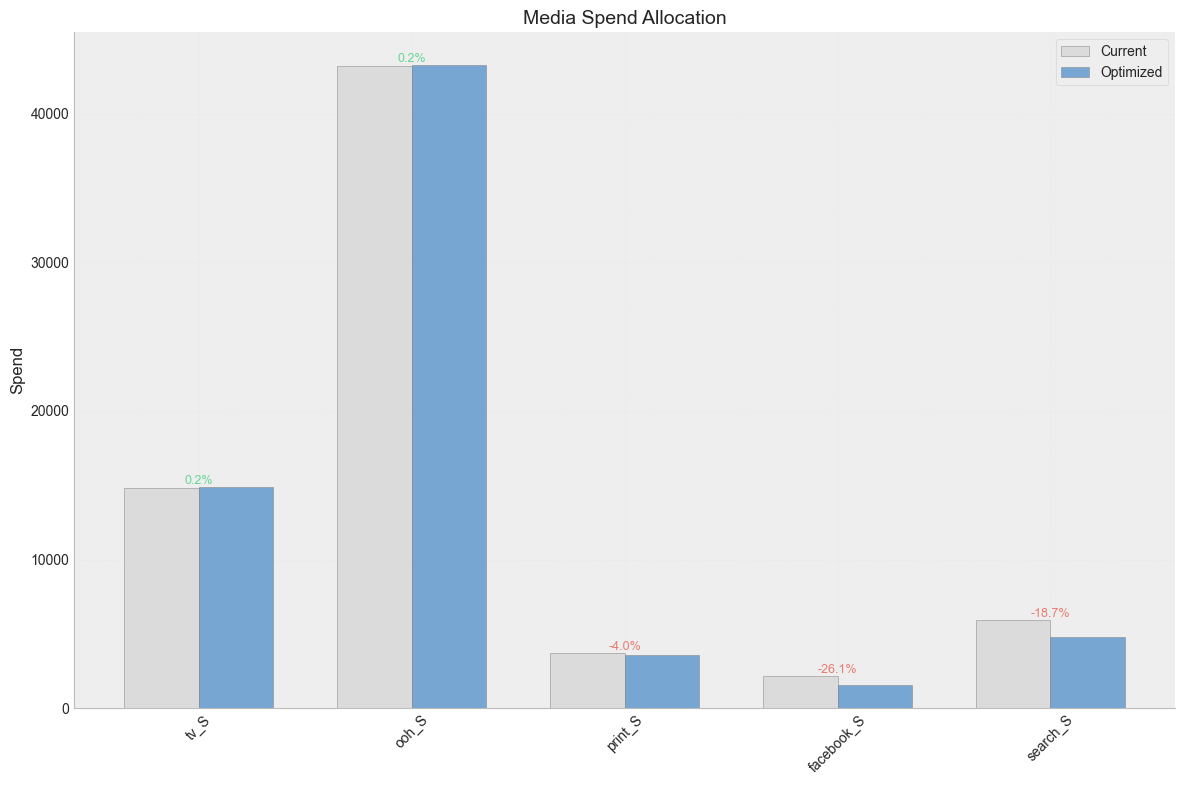

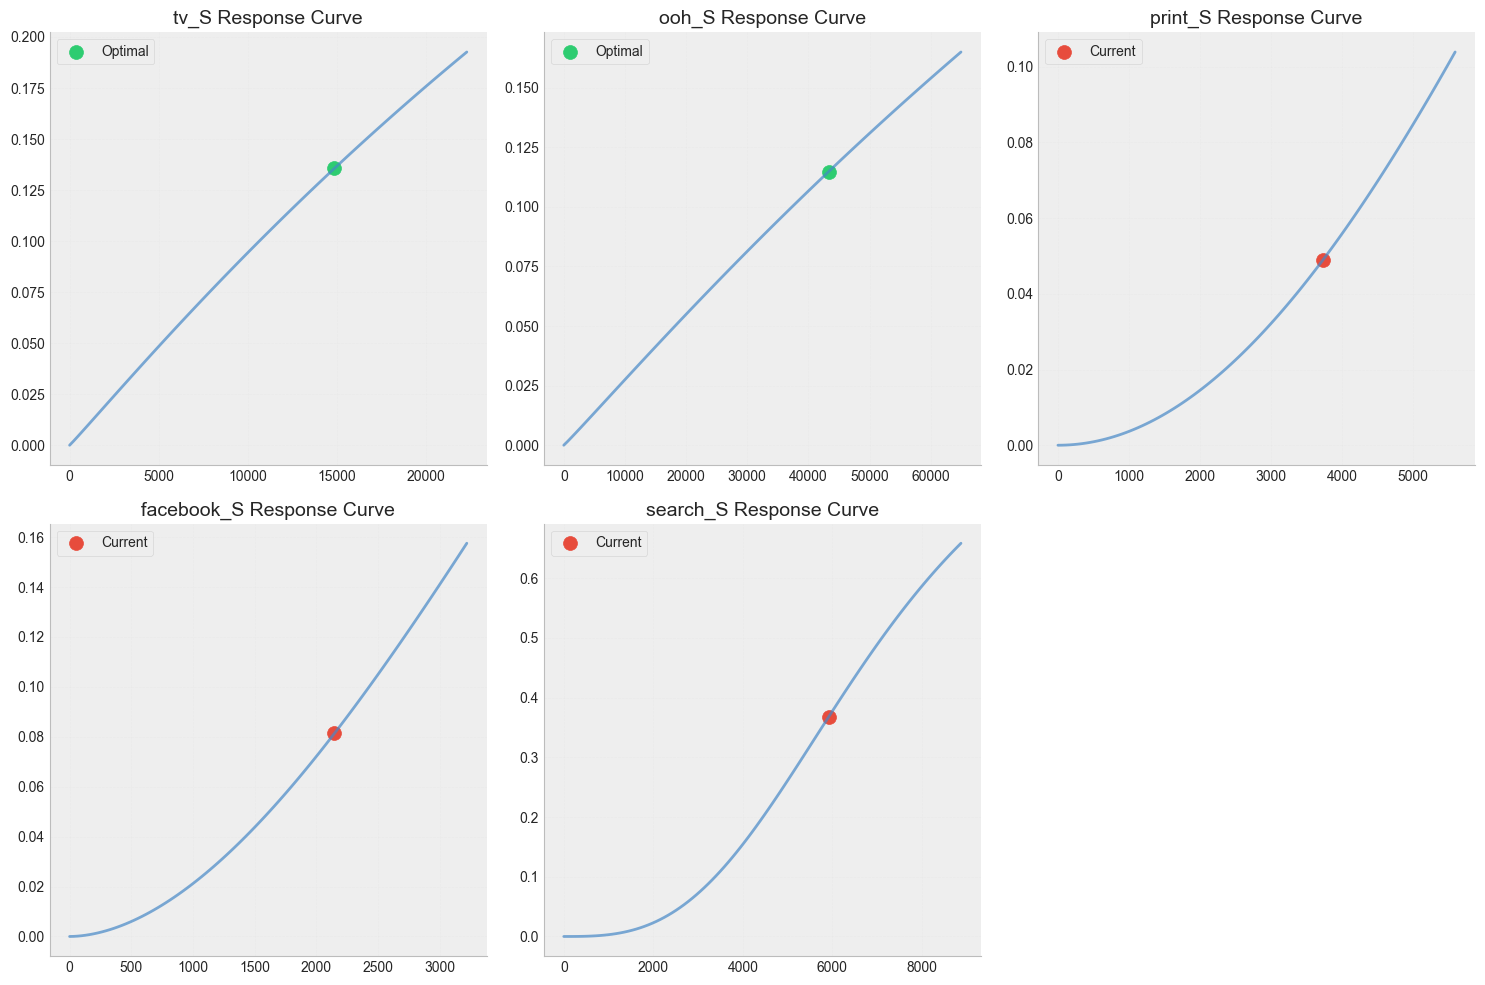

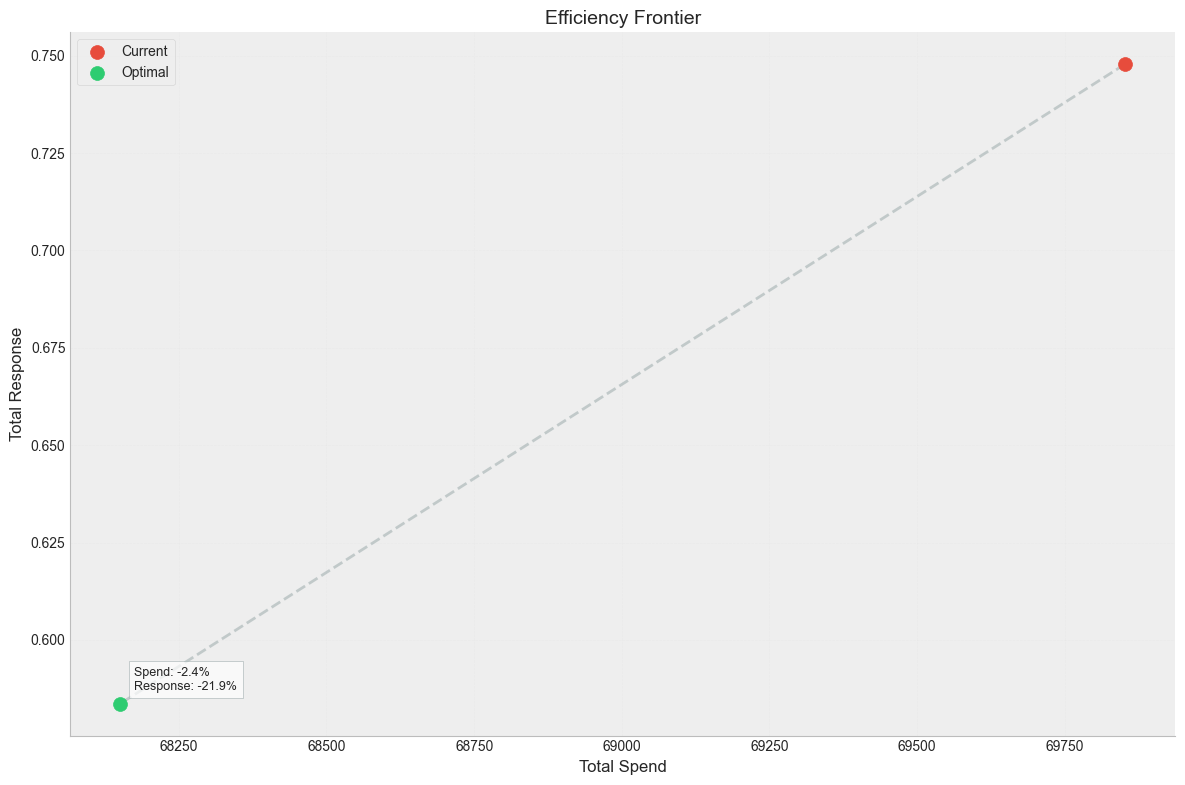

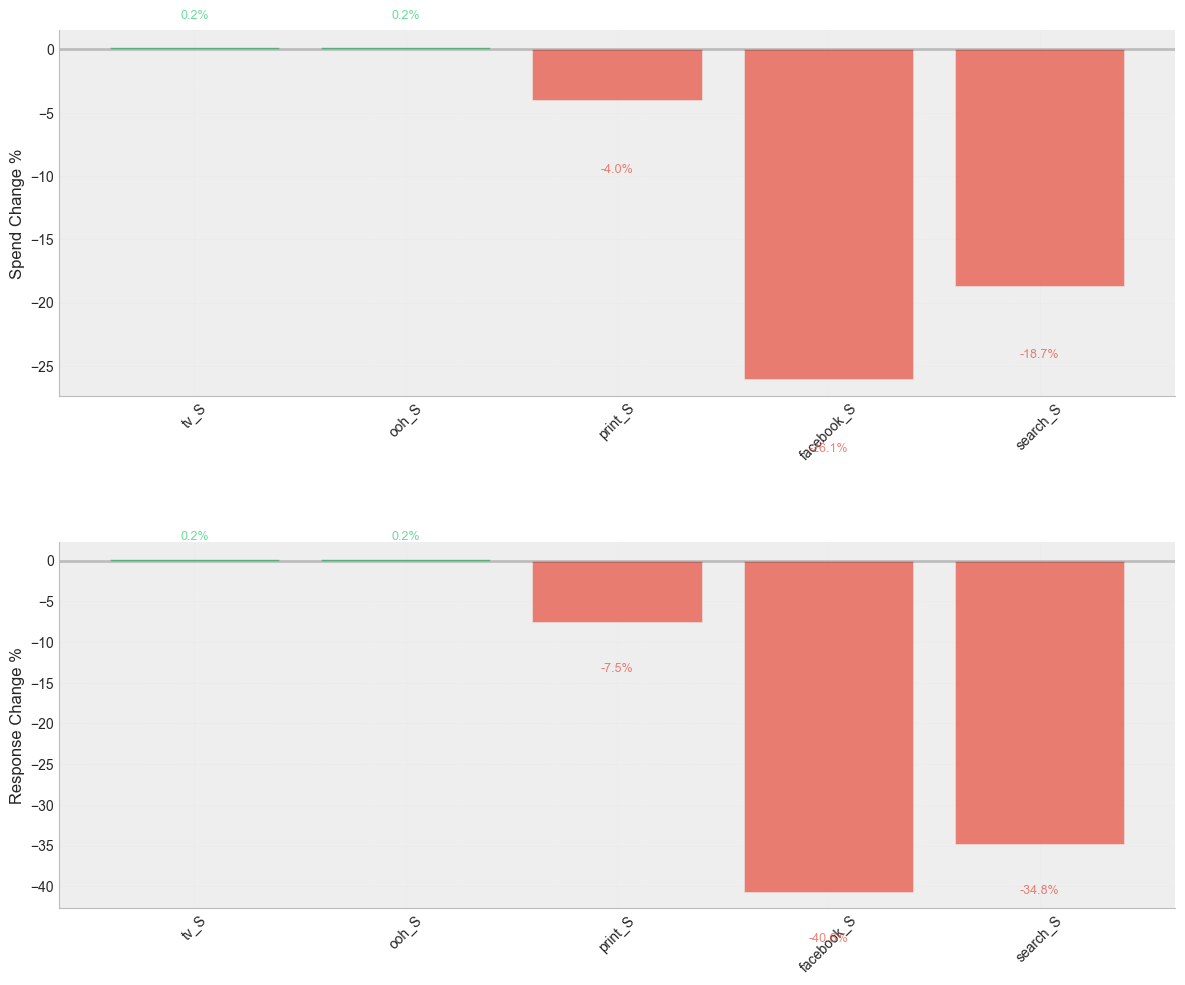

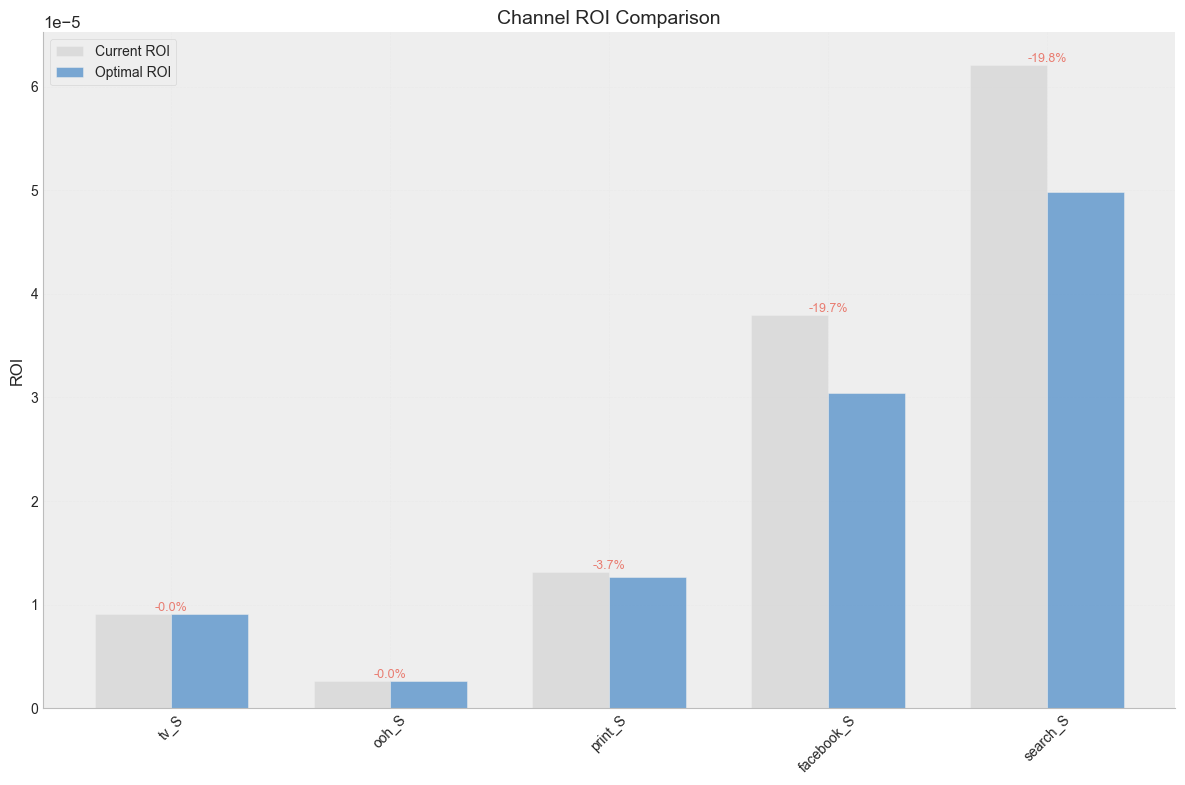

In [23]:
# Create visualizations for each scenario
max_response_plotter = AllocationPlotter(result)
target_efficiency_plotter = AllocationPlotter(result3)

# Generate plots
max_response_plots = max_response_plotter.plot_all()
target_efficiency_plots = target_efficiency_plotter.plot_all()

# Display plots
print("Max Response Scenario Plots:")
print("-" * 50)
for plot_name, fig in max_response_plots.items():
    display(fig)


print("\nTarget Efficiency Scenario Plots:")
print("-" * 50)
for plot_name, fig in target_efficiency_plots.items():
    display(fig)